In [2]:
from scipy.stats import lognorm, norm
import matplotlib.pyplot as plt
import numpy as np
from math import exp, sqrt
from numba import njit
from datetime import datetime
import pandas_datareader.data as web


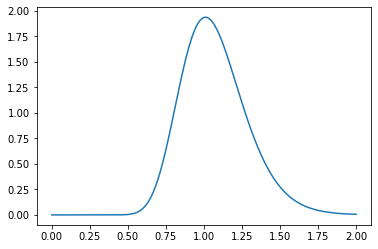

In [3]:
mu = 0.05
sigma = 0.2

x = np.linspace(0, 2, 1000)
y = lognorm.pdf(x, sigma, 0, exp(mu))

plt.plot(x, y)
plt.show()

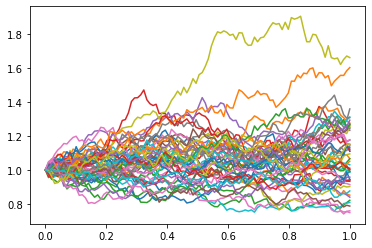

In [4]:
# @numba.njit()
def generate_simulation(nsim, nt):
    t0, t1 = 0, 1

    t = np.linspace(t0, t1, nt)
    dt = (t1-t0)/nt

    s = np.zeros((nsim, nt))
    s[:, 0] = 1

    for j in range(0, nt-1):
        s[:, j+1] = s[:,j] * np.exp((mu-sigma**2/2)*dt \
                        +sigma*np.sqrt(dt)*np.random.normal(0, 1, nsim))

    return t, s

nsim, nt = 50, 100
jitted_fn = njit()(generate_simulation)
t, prices = jitted_fn(nsim, nt)

for j in range(0, nsim):
    plt.plot(t, prices[j,:])

plt.show()

In [5]:
%timeit generate_simulation(nsim, nt)
%timeit jitted_fn(nsim, nt)

1.46 ms ± 179 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
338 µs ± 90.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


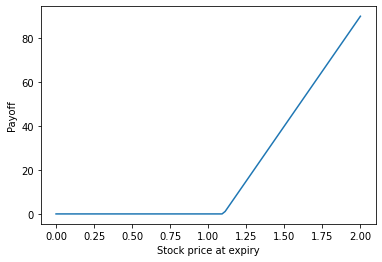

In [6]:
# payoff curve

k = 1.1

def payoff(x):
    return 100*np.maximum(0,x-k)

x=np.linspace(0,2, 100)
y=payoff(x)
plt.plot(x,y)
plt.xlabel('Stock price at expiry')
plt.ylabel('Payoff')
plt.show()

In [7]:
# monte carlo simulation

Nsim = 10000000
amount_underlying = 100
strike = 1.1
sigma = 0.2
mu = 0.06
r = 0.015

@njit()
def payoff(x):
    return amount_underlying * np.maximum(0, x-strike)

num0 = np.random.normal(0,1,Nsim)
S0 = 15
S1 = np.exp(r-sigma**2/2+sigma*num0)
C0 = exp(-r)*np.mean(payoff(S1))
print(C0)

4.77353519640899


In [8]:
# black scholes model calculation
s0 = 1
sigma = 0.2
r = 0.015
t = 1

def d1(sigma,k,t,r,x):
    return (np.log(x/k) + (r+sigma**2/2)*t)/(sigma*np.sqrt(t))

def d2(sigma,k,t,r,x):
    return d1(sigma,k,t,r,x) - sigma*np.sqrt(t)

def bs_call(amount_underlying, sigma,k,t,r,x):
    d1_val = d1(sigma,k,t,r,x)
    d2_val = d2(sigma,k,t,r,x)
    temp = norm.cdf(d1_val)*x-norm.cdf(d2_val)*k*np.exp(-r*t)
    return amount_underlying * temp

c0 = bs_call(amount_underlying, sigma, strike, t, r, s0)
print(c0)

4.775025500484964


In [5]:
def calc_sigma(stock):
    today = datetime.now()
    df = web.DataReader(stock, 'yahoo', today.replace(year=today.year-1))
    df.sort_values(by='Date', inplace=True)
    df.dropna(inplace=True)
    df = df.assign(close_day_before=df.Close.shift(1))
    df['returns'] = ((df.Close - df.close_day_before)/df.close_day_before)

    return np.sqrt(252) * df['returns'].std()

def calc_r():
    today = datetime.now()
    return (web.DataReader('^TNX', 'yahoo', today.replace(day=today.day-1), today)['Close'].iloc[-1])/100

print(calc_sigma('SPY'))
print(calc_r())

0.12514554488400237
0.014479999542236327


In [6]:
# implied volatility
# opt_type 0 for call and 1 for put
def calc_implied_volatility(price, S, K, T, r, opt_type=0):
    sigma = 0.001
    while sigma < 1:

        if opt_type:
            price_implied = S * \
                norm.cdf(d1(S, K, T, r, sigma)) -K * exp(-r*T) * \
                norm.cdf(d2(S, K, T, r, sigma))
        else:
            price_implied = K * exp(-r*T)-S+bs_call(S, K, T, r, sigma)

        if price-price_implied < 0.001:
            return sigma

        sigma += 0.001

    return "Not Found"

In [7]:
"""
greeks

delta: sensitivity of an option price changes relative to changes in underlying asset's price
gamma: delta's change relative to changes in price of underlying asset
vega: sensitivity of an option price relative to the volatility of the underlying asset
theta: sensitivity of an option price relative to the option's time to maturity
rho: sensitivity of the option price relative to interest rates

"""


def call_delta(S,K,T,r,sigma):
    return norm.cdf(d1(S,K,T,r,sigma))
def call_gamma(S,K,T,r,sigma):
    return norm.pdf(d1(S,K,T,r,sigma))/(S*sigma*sqrt(T))
def call_vega(S,K,T,r,sigma):
    return 0.01*(S*norm.pdf(d1(S,K,T,r,sigma))*sqrt(T))
def call_theta(S,K,T,r,sigma):
    return 0.01*(-(S*norm.pdf(d1(S,K,T,r,sigma))*sigma)/(2*sqrt(T)) - r*K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma)))
def call_rho(S,K,T,r,sigma):
    return 0.01*(K*T*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma)))

def put_delta(S,K,T,r,sigma):
    return -norm.cdf(-d1(S,K,T,r,sigma))
def put_gamma(S,K,T,r,sigma):
    return norm.pdf(d1(S,K,T,r,sigma))/(S*sigma*sqrt(T))
def put_vega(S,K,T,r,sigma):
    return 0.01*(S*norm.pdf(d1(S,K,T,r,sigma))*sqrt(T))
def put_theta(S,K,T,r,sigma):
    return 0.01*(-(S*norm.pdf(d1(S,K,T,r,sigma))*sigma)/(2*sqrt(T)) + r*K*exp(-r*T)*norm.cdf(-d2(S,K,T,r,sigma)))
def put_rho(S,K,T,r,sigma):
    return 0.01*(-K*T*exp(-r*T)*norm.cdf(-d2(S,K,T,r,sigma)))
